In [1]:
from clearml import Task
import numpy as np
import random
import os
import optuna

SEED = 42 # vẫn phải chọn random của model đấy

# Python, NumPy
random.seed(SEED)
np.random.seed(SEED) 

# Hash seed cho Python interpreter (ảnh hưởng tới dict order)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Giới hạn luồng tính toán song song (để tránh floating-point nondeterminism)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# tạo sampler của Optuna có seed cố định
sampler = optuna.samplers.TPESampler(seed=SEED)





c:\Users\Admin\Documents\ML\group1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import joblib
import pandas as pd
import optuna.visualization as vis

from pathlib import Path
from clearml import Logger
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import TimeSeriesSplit

from src import data_preprocessing as dp
from src import pipeline as pl
from src import feature_engineering as fe
from src.model_evaluation import evaluate
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

In [10]:
# thay bằng task_id thực tế của task bạn muốn cập nhật
# Lấy task đã tồn tại bằng task_id
task = Task.get_task(task_id="6ccb6c6f476d46c991d0653fdc21123a")


In [3]:
# 1. Load raw Data
print('step 1')
df = dp.load_data(r"data\raw data\Hanoi Daily 10 years.csv")


# 2. basic preprocessing for all data set
# đang để là có drop description 
print()
print('step 2')
df = dp.basic_preprocessing(df=df)
print("Shape:", df.shape)


# 3. chia train, val, test (tỉ lệ 70/15/15)
print()
print('step 3')

target_col = 'temp'
train_size = 0.7
val_size = 0.15
n = len(df)

train_df = df.iloc[:int(train_size*n)]
val_df = df.iloc[int(train_size*n):int((train_size+val_size)*n)]
test_df = df.iloc[int((train_size+val_size)*n):]

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

step 1
 Loaded data with shape: (3660, 33)

step 2
Dropped column: 'description'
Dropped column: 'severerisk'
Dropped column: 'icon'
Dropped column: 'stations'
Shape: (3660, 28)

step 3
Train: 2562, Val: 549, Test: 549


In [4]:
# 4. Fit và transform trên preprocessing pipeline
pipeline1 = pl.build_preprocessing_pipeline()

# fit trên train
pipeline1.fit(train_df)

# transform 
train_processed = pipeline1.transform(train_df)
val_processed = pipeline1.transform(val_df)
test_processed = pipeline1.transform(test_df)



In [6]:
# Tạo feature engineering
column_lag = ['temp','tempmax', 'tempmin', 'dew', 'humidity', 'precip',
    'precipprob', 'precipcover', 'windgust', 'windspeed',
    'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 
    'pressure_temp_index', 'wind_temp_index', 'temp_range', 'dew_spread']
train_feat = fe.feature_engineering(train_processed, column= column_lag)
val_feat = fe.feature_engineering(val_processed, column= column_lag)
test_feat = fe.feature_engineering(test_processed, column= column_lag)
print(train_feat.shape)


(2562, 253)


In [7]:
# Hiển thị toàn bộ dòng và cột
print(", ".join(train_feat.columns))


temp, tempmax_lag_1, tempmin_lag_1, temp_lag_1, dew_lag_1, humidity_lag_1, precip_lag_1, precipprob_lag_1, precipcover_lag_1, windgust_lag_1, windspeed_lag_1, winddir_lag_1, sealevelpressure_lag_1, cloudcover_lag_1, visibility_lag_1, solarradiation_lag_1, moonphase_lag_1, sunrise_lag_1, sunset_lag_1, conditions_lag_1, month_lag_1, weekday_lag_1, month_sin_lag_1, month_cos_lag_1, day_length_lag_1, temp_range_lag_1, dew_spread_lag_1, humidity_high_lag_1, rain_binary_lag_1, rain_intensity_lag_1, wind_temp_index_lag_1, pressure_temp_index_lag_1, humidity_cloud_index_lag_1, solar_temp_index_lag_1, uv_cloud_index_lag_1, wind_variability_lag_1, foggy_lag_1, temp_lag_2, temp_lag_3, temp_lag_4, temp_lag_5, temp_lag_6, temp_lag_7, tempmax_lag_2, tempmax_lag_3, tempmax_lag_4, tempmax_lag_5, tempmax_lag_6, tempmax_lag_7, tempmin_lag_2, tempmin_lag_3, tempmin_lag_4, tempmin_lag_5, tempmin_lag_6, tempmin_lag_7, dew_lag_2, dew_lag_3, dew_lag_4, dew_lag_5, dew_lag_6, dew_lag_7, humidity_lag_2, humidit

In [8]:
# Chia X, y riêng biệt
X_train, y_train = train_feat.drop(columns=[target_col]), train_df[target_col]
X_val, y_val = val_feat.drop(columns=[target_col]), val_df[target_col]
X_test, y_test = test_feat.drop(columns=[target_col]), test_df[target_col]

print(f"Train: {X_train.shape, y_train.shape}, Val: {X_val.shape, y_val.shape}, Test: {X_test.shape, y_test.shape}")

Train: ((2562, 252), (2562,)), Val: ((549, 252), (549,)), Test: ((549, 252), (549,))


In [9]:
# thử chỉ có preprocessing
X_train_base, y_train_base = train_processed.drop(columns=[target_col]), train_df[target_col]
X_val_base, y_val_base = val_processed.drop(columns=[target_col]), val_df[target_col]
X_test_base, y_test_base = test_processed.drop(columns=[target_col]), test_df[target_col]

# X_train_base = X_train.drop(['sunrise', 'sunset'], axis= 1)
# X_val_base = X_val.drop(['sunrise', 'sunset'], axis= 1)
# X_test_base= X_test.drop(['sunrise', 'sunset'], axis= 1)

print(f"Train: {X_train_base.shape, y_train.shape}, Val: {X_val_base.shape, y_val.shape}, Test: {X_test_base.shape, y_test.shape}")

Train: ((2562, 37), (2562,)), Val: ((549, 37), (549,)), Test: ((549, 37), (549,))


### Random Forest

In [10]:
# 1. fit 
model1 = RandomForestRegressor(n_estimators = 100, min_samples_split=2, min_samples_leaf=1,min_impurity_decrease=0, 
                               max_depth= 7, max_features= None, bootstrap= True, oob_score= False, 
                               max_leaf_nodes= None, max_samples= None, random_state= 42
                               )
model1.fit(X_train, y_train) # sau này đầy đủ feature engineering thì thay X đầy đủ feature vào

# 2. predict
y_pred_val = model1.predict(X_val) 
y_pred_test = model1.predict(X_test)

In [11]:
# Lấy feature importance
importances = model1.feature_importances_

# Tạo DataFrame hiển thị
feat_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importance)

                      Feature    Importance
2                  temp_lag_1  8.719595e-01
1               tempmin_lag_1  2.788409e-02
30  pressure_temp_index_lag_1  2.403750e-02
9             windspeed_lag_1  7.132565e-03
8              windgust_lag_1  4.534253e-03
..                        ...           ...
74           precipprob_lag_4  1.139459e-06
77           precipprob_lag_7  3.766489e-07
73           precipprob_lag_3  1.515299e-07
72           precipprob_lag_2  0.000000e+00
35                foggy_lag_1  0.000000e+00

[252 rows x 2 columns]


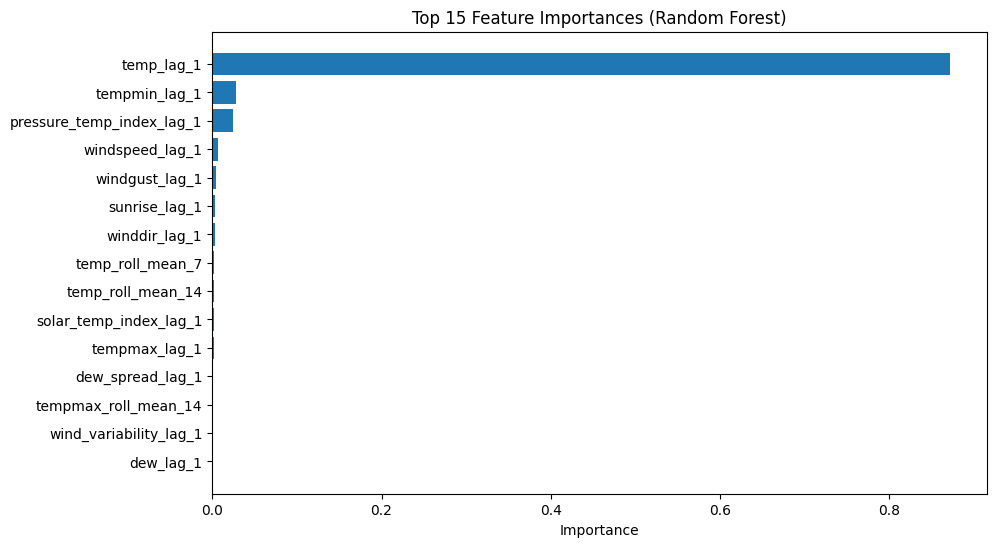

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feat_importance['Feature'][:15], feat_importance['Importance'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()


In [13]:
# Đánh giá sơ bộ trước khi tune

# 3. Evaluate on validation
val_metrics = evaluate(y_val, y_pred_val)
print("Validation metrics:", val_metrics)

# 4. Evaluate on test
test_metrics = evaluate(y_test, y_pred_test)
print("Test metrics:", test_metrics)

# 5. Save model 
model_path = r'models/RF_model.pkl' 
joblib.dump(model1, model_path)
print(f"RandomForest model saved to {model_path}")



Validation metrics: {'RMSE': np.float64(1.5947420272865784), 'R2': 0.904375190572565, 'MAPE': np.float64(5.370479272607208)}
Test metrics: {'RMSE': np.float64(1.4048978311934608), 'R2': 0.9088047388756998, 'MAPE': np.float64(4.457994638536641)}
RandomForest model saved to models/RF_model.pkl


In [14]:
def objective(trial):
    # Hyperparameter space
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.0, 0.5)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    #bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    #oob_score = trial.suggest_categorical('oob_score', [False, True]) if bootstrap else False
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 1000)
    #max_samples = trial.suggest_float('max_samples', 0.5, 1.0) if bootstrap else None

    # Model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_impurity_decrease=min_impurity_decrease,
        max_features=max_features,
        bootstrap= False,
        oob_score= False,
        max_leaf_nodes=max_leaf_nodes,
        max_samples= None,
        random_state=42,
        n_jobs=-1
    )

    # Time series CV
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_idx, val_idx in cv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred_val = model.predict(X_val)

        metrics = evaluate(y_val, y_pred_val)
        rmse_scores.append(metrics['RMSE'])

    # Trả về RMSE trung bình của các cv để Optuna minimize
    return np.mean(rmse_scores)


In [15]:
study = optuna.create_study(direction='minimize', sampler=sampler)  # minimize RMSE
study.optimize(objective, n_trials=50)
print("Best parameters:", study.best_trial.params)
print("Best RMSE:", study.best_value)


[I 2025-10-18 19:02:15,998] A new study created in memory with name: no-name-1198b350-4c60-4735-833e-4b6ec24126d6
[I 2025-10-18 19:03:54,081] Trial 0 finished with value: 1.9222961423389961 and parameters: {'n_estimators': 437, 'max_depth': 48, 'min_samples_split': 8, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.07800932022121826, 'max_features': None, 'max_leaf_nodes': 605}. Best is trial 0 with value: 1.9222961423389961.
[I 2025-10-18 19:06:24,804] Trial 1 finished with value: 2.008556664600326 and parameters: {'n_estimators': 737, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.10616955533913808, 'max_features': None, 'max_leaf_nodes': 530}. Best is trial 0 with value: 1.9222961423389961.
[I 2025-10-18 19:08:01,607] Trial 2 finished with value: 2.0212229655663627 and parameters: {'n_estimators': 489, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.14607232426760908, 'max_features': None, 'max_

Best parameters: {'n_estimators': 923, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0008010072428880139, 'max_features': 'sqrt', 'max_leaf_nodes': 933}
Best RMSE: 1.6045203861328527


In [16]:
study.best_params

{'n_estimators': 923,
 'max_depth': 32,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'min_impurity_decrease': 0.0008010072428880139,
 'max_features': 'sqrt',
 'max_leaf_nodes': 933}

In [17]:
best_params = study.best_params

In [18]:
# ! pip install plotly

In [19]:
vis.plot_optimization_history(study)


In [20]:
vis.plot_parallel_coordinate(study)

In [21]:
vis.plot_slice(study=study)

| **Tham số**               | **Giải thích ngắn gọn**                                                                            |
| ------------------------- | -------------------------------------------------------------------------------------------------- |
| **n_estimators**          | Số lượng cây (trees) trong rừng. Càng nhiều cây → mô hình càng ổn định, nhưng chậm hơn.            |
| **max_depth**             | Độ sâu tối đa của mỗi cây. Giới hạn độ phức tạp của cây để tránh overfitting.                      |
| **min_samples_split**     | Số mẫu tối thiểu cần có để một node được chia. Tăng giá trị này giúp giảm overfitting.             |
| **min_samples_leaf**      | Số mẫu tối thiểu cần có ở mỗi lá (leaf node). Tăng giá trị → cây “mượt” hơn, ít nhạy với nhiễu.    |
| **min_impurity_decrease** | Mức giảm impurity tối thiểu để chấp nhận chia node. Giúp kiểm soát việc chia nhỏ không cần thiết.  |
| **max_features**          | Số lượng đặc trưng (features) được xem xét tại mỗi lần chia. Giúp tạo sự đa dạng giữa các cây.     |
| **bootstrap**             | Nếu `True`, dùng **sampling có hoàn lại** để huấn luyện từng cây (bootstrap sampling).             |
| **oob_score**             | Nếu `True`, dùng **out-of-bag samples** để ước lượng độ chính xác (giống cross-validation nội bộ). |
| **max_leaf_nodes**        | Giới hạn số lượng node lá tối đa của mỗi cây. Giúp đơn giản hóa mô hình.                           |
| **max_samples**           | Số lượng mẫu (hoặc tỉ lệ) được lấy ngẫu nhiên từ tập huấn luyện cho mỗi cây khi dùng bootstrap.    |
| **random_state**          | Hạt giống ngẫu nhiên để tái lập kết quả (đảm bảo chạy lại vẫn ra kết quả giống).                   |
| **n_jobs**                | Số lượng CPU chạy song song. `-1` nghĩa là dùng **t_**                                             |


In [22]:
vis.plot_param_importances(study=study)

In [23]:
# creating new model
best_n_estimators= best_params['n_estimators']
best_max_depth= best_params['max_depth']
best_min_samples_split= best_params['min_samples_split']
best_min_samples_leaf= best_params['min_samples_leaf']
best_min_impurity_decrease= best_params['min_impurity_decrease']
best_max_features= best_params['max_features']
best_bootstrap= False
best_oob_score= False
best_max_leaf_nodes= best_params['max_leaf_nodes']
best_max_samples= None

In [24]:
best_model = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    min_impurity_decrease=best_min_impurity_decrease,
    max_features=best_max_features,
    bootstrap=best_bootstrap,
    oob_score=best_oob_score,
    max_leaf_nodes=best_max_leaf_nodes,
    max_samples=best_max_samples,
    random_state=42,  # thêm để đảm bảo reproducibility
    n_jobs=-1         # tận dụng toàn bộ CPU cores
)

In [25]:
best_model.fit(X_train,y_train)

,n_estimators,923
,criterion,'squared_error'
,max_depth,32
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,933
,min_impurity_decrease,0.0008010072428880139
,bootstrap,False
,oob_score,False


In [29]:
# 2. predict
y_pred_val = best_model.predict(X_val) 
y_pred_test = best_model.predict(X_test)

# 3. Evaluate on validation
val_metrics = evaluate(y_val, y_pred_val)
print("Validation metrics:", val_metrics)

# 4. Evaluate on test
test_metrics = evaluate(y_test, y_pred_test)
print("Test metrics:", test_metrics)

# 5. Save model 
model_path = r'models/Tuning_RF_model.pkl' 
joblib.dump(best_model, model_path)
print(f"RandomForest model saved to {model_path}")


Validation metrics: {'RMSE': np.float64(1.5969372850924521), 'R2': 0.9041117428296458, 'MAPE': np.float64(5.612991776463948)}
Test metrics: {'RMSE': np.float64(1.4119494229735612), 'R2': 0.9078869701643867, 'MAPE': np.float64(4.5023913053845765)}
RandomForest model saved to models/Tuning_RF_model.pkl


In [ ]:
# Log model lên ClearML
task.update_output_model("tune_1_RF_Model", model_path)

In [27]:
# Validation metrics: {'RMSE': np.float64(1.5947420272865784), 'R2': 0.904375190572565, 'MAPE': np.float64(5.370479272607208)}
# Test metrics: {'RMSE': np.float64(1.4048978311934608), 'R2': 0.9088047388756998, 'MAPE': np.float64(4.457994638536641)}
# RandomForest model saved to models/RF_model.pkl

### Extra Tree

In [28]:
model2 = ExtraTreesClassifier(
    n_estimators=100,    # số cây
    max_features='sqrt', # số feature được xem khi split
    random_state=42
)

### Gradient Boosting (tại model này chưa học, tìm hiểu đã rồi rảnh thì làm random 1 trong 3 đứa :))))